In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import missingno as msno
import os
import pandas as pd
import pickle
import re
import requests
import seaborn as sns

from db import create_connection
from db import (
    articles,
    services,
    urls
)

In /home/adsum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/adsum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/adsum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/adsum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/adsum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
import os
current_path = os.path.abspath(os.getcwd())
datasets_directory = os.path.join(current_path, 'datasets')

if not os.path.exists(datasets_directory):
    os.makedirs(datasets_directory)

In [3]:
connection = create_connection()

# Get data

In [4]:
data = articles.get_articles(connection)

In [5]:
pd.set_option('max_colwidth', 100)
df = pd.DataFrame(data, columns = ['publication_date',
                                   'author',
                                   'title',
                                   'url',
                                   'koronawirus_in_text',
                                   'koronawirus_in_title',
                                   'question_mark',
                                   'exclamation_mark',
                                   'all_words'])

In [6]:
df.sample(frac = 0.001)

,publication_date,author,title,url,koronawirus_in_text,koronawirus_in_title,question_mark,exclamation_mark,all_words
2081,NaT,None,None,https://www.se.pl/lublin/noc-kultury-2019-juz-w-najblizszy-weekend-czego-nie-mozna-ominac-video-...,NaN,NaN,NaN,NaN,NaN
7496,NaT,None,None,https://www.se.pl/lublin/swieto-niepodleglosci-11-listopada-w-lublinie-program-defilada-koncert-...,NaN,NaN,NaN,NaN,NaN
4038,NaT,None,None,https://www.se.pl/lublin/eska-w-krasniku-eska-krasnik-letnia-scena-eski-krasnik-maliniaki-krasni...,NaN,NaN,NaN,NaN,NaN
2867,NaT,None,None,https://www.se.pl/lublin/mrozy-nie-odpuszczaja-zapytalismy-mieszkancow-lublina-jak-sobie-z-nim-r...,NaN,NaN,NaN,NaN,NaN
5031,NaT,None,None,https://www.se.pl/lublin/wyburzanie-wiaduktu-na-grygowej-w-lublinie-objazdy-dla-kierowcow-audio-...,NaN,NaN,NaN,NaN,NaN
8494,2020-03-10,mt,Koronawirus w Lubelskiem? ZNAMY WYNIKI pacjentów w szpitalach [AKTUALIZACJA],https://www.se.pl/lublin/koronawirus-w-lubelskiem-piec-osob-w-szpitalach-trwaja-kwarantanny-rapo...,23.0,1.0,2.0,1.0,243.0
12,2020-09-08,Mariusz Mucha,Rozbił auto na domu babci Helenki. 98-latka nie była zadowolona,https://lublin.se.pl/rozbil-auto-na-domu-babci-helenki-98-latka-nie-byla-zadowolona-aa-HvFK-KmAb...,0.0,0.0,0.0,1.0,298.0
7002,NaT,None,None,https://www.se.pl/lublin/lublin-przekrety-na-ponad-94-milionow-zlotych-miedzynarodowa-grupa-rozb...,NaN,NaN,NaN,NaN,NaN
5058,NaT,None,None,https://www.se.pl/lublin/lublin-hodowla-marihuany-zlikwidowana-policjanci-zabezpieczyli-tez-bron...,NaN,NaN,NaN,NaN,NaN


# Clean data

### initial data check, organize and clearing

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   publication_date      1744 non-null   datetime64[ns]
 1   author                1744 non-null   object        
 2   title                 1744 non-null   object        
 3   url                   8610 non-null   object        
 4   koronawirus_in_text   1744 non-null   float64       
 5   koronawirus_in_title  1744 non-null   float64       
 6   question_mark         1744 non-null   float64       
 7   exclamation_mark      1744 non-null   float64       
 8   all_words             1744 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 2.6 MB


In [8]:
df.nunique()

publication_date         243
author                   126
title                   1741
url                     8610
koronawirus_in_text       35
koronawirus_in_title       2
question_mark             18
exclamation_mark          15
all_words                393
dtype: int64

In [9]:
df.dropna(inplace=True)
df.shape

(1744, 9)

<AxesSubplot:>

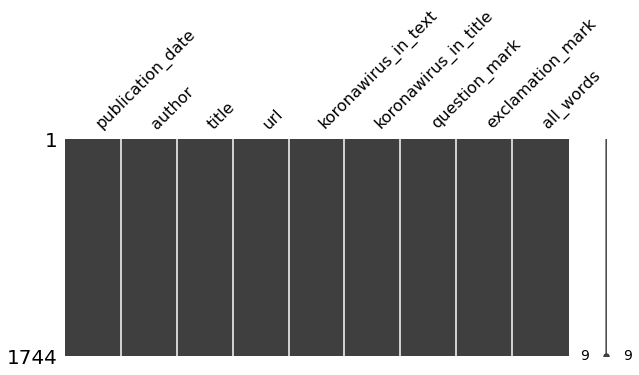

In [12]:
df.isnull().sum()
msno.matrix(df, figsize=(10,4))

In [14]:
df['author'] = df['author'].astype('category')
df['koronawirus_in_text'] = df['koronawirus_in_text'].astype('int')
df['koronawirus_in_title'] = df['koronawirus_in_title'].astype('int')
df['question_mark'] = df['question_mark'].astype('int')
df['exclamation_mark'] = df['exclamation_mark'].astype('int')
df['all_words'] = df['all_words'].astype('int')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 8609
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   publication_date      1744 non-null   datetime64[ns]
 1   author                1744 non-null   category      
 2   title                 1744 non-null   object        
 3   url                   1744 non-null   object        
 4   koronawirus_in_text   1744 non-null   int64         
 5   koronawirus_in_title  1744 non-null   int64         
 6   question_mark         1744 non-null   int64         
 7   exclamation_mark      1744 non-null   int64         
 8   all_words             1744 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(2)
memory usage: 806.1 KB


In [15]:
df.describe()

,koronawirus_in_text,koronawirus_in_title,question_mark,exclamation_mark,all_words
count,1744.000000,1744.000000,1744.000000,1744.000000,1744.000000
mean,4.148509,0.215596,1.252294,1.368693,254.772936
std,19.809890,0.411353,3.527369,4.032138,420.661451
min,0.000000,0.000000,0.000000,0.000000,51.000000
25%,0.000000,0.000000,0.000000,0.000000,172.000000
50%,0.000000,0.000000,1.000000,1.000000,215.000000
75%,3.000000,0.000000,2.000000,2.000000,273.000000
max,525.000000,1.000000,99.000000,123.000000,11082.000000


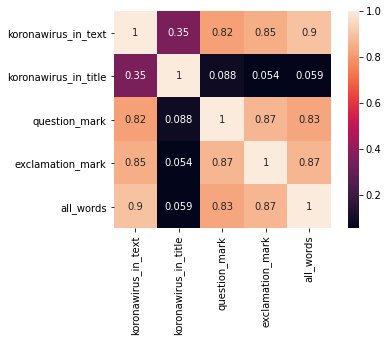

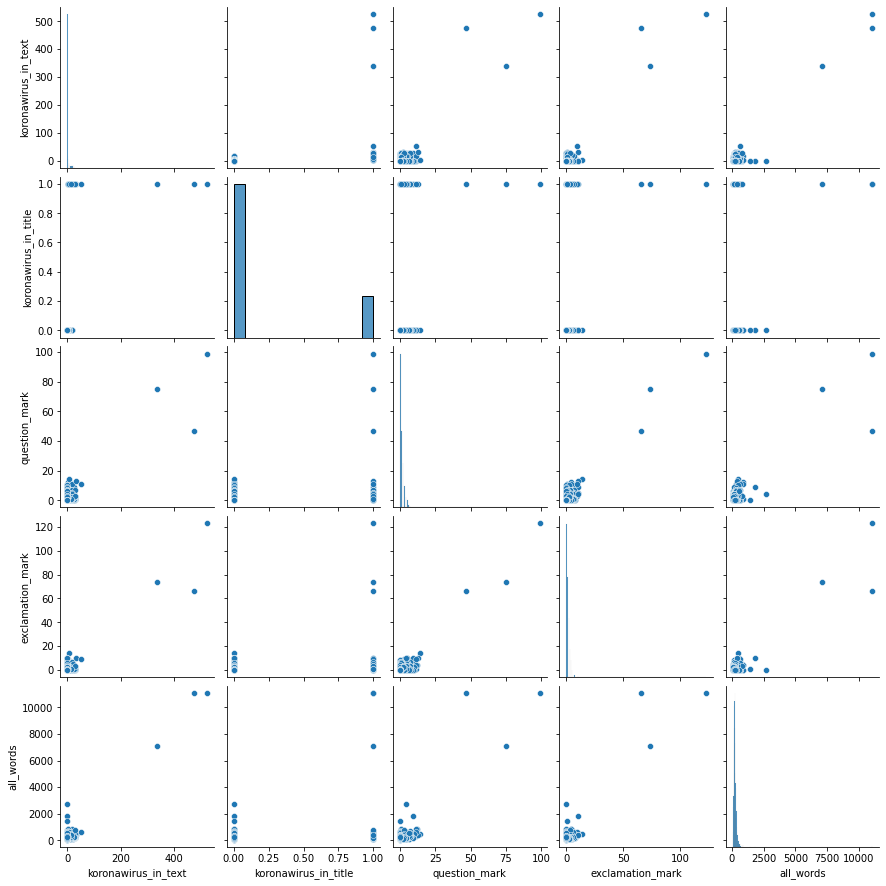

In [16]:
 # Detect dependencies in the data
corr = df.corr()
sns.heatmap(data=corr, square=True , annot=True, cbar=True)
sns.pairplot(df)

### column: publication_day

In [12]:
df.publication_date.value_counts().head()

2020-06-29    28
2020-07-08    26
2020-07-01    25
2020-07-03    22
2020-08-25    22
Name: publication_date, dtype: int64

In [13]:
df['publication_date'].nunique()

243

In [14]:
#df['publication_day'] = df['publication_day'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 8609
Data columns (total 9 columns):
publication_date        1744 non-null datetime64[ns]
author                  1744 non-null category
title                   1744 non-null object
url                     1744 non-null object
koronawirus_in_text     1744 non-null int64
koronawirus_in_title    1744 non-null int64
question_mark           1744 non-null int64
exclamation_mark        1744 non-null int64
all_words               1744 non-null int64
dtypes: category(1), datetime64[ns](1), int64(5), object(2)
memory usage: 806.1 KB


### column: publication_month

In [15]:
df.insert(loc=1, column='publication_month', value=df['publication_date'].dt.strftime('%Y-%m'))
df.sample(frac = 0.001)

,publication_date,publication_month,author,title,url,koronawirus_in_text,koronawirus_in_title,question_mark,exclamation_mark,all_words
777,2020-04-06,2020-04,Michał Michalak,W całej Polsce nie ma chętnych do komisji wyborczych! Największe braki w Lublinie!,https://www.se.pl/lublin/w-calej-polsce-nie-ma-chetnych-do-komisji-wyborczych-najwieksze-braki-w...,0,0,0,0,171
507,2020-06-29,2020-06,"Mucha, mta",Krasnystaw: Podczas remontu odkopali POCISK. Ze sprawnym zapalnikiem,https://lublin.se.pl/krasnystaw-podczas-remontu-odkopali-pocisk-ze-sprawnym-zapalnikiem-aa-XgLU-...,0,0,0,2,120


In [16]:
df.publication_month.value_counts().head(8)

2020-07    439
2020-08    301
2020-06    214
2020-01    154
2020-05    153
2020-03    147
2020-04    138
2020-02    105
Name: publication_month, dtype: int64

In [17]:
df['publication_month'].nunique()

9

In [18]:
df = df.loc[df['publication_month'].isin(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08'])]

In [19]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651 entries, 57 to 8609
Data columns (total 10 columns):
publication_date        1651 non-null datetime64[ns]
publication_month       1651 non-null object
author                  1651 non-null category
title                   1651 non-null object
url                     1651 non-null object
koronawirus_in_text     1651 non-null int64
koronawirus_in_title    1651 non-null int64
question_mark           1651 non-null int64
exclamation_mark        1651 non-null int64
all_words               1651 non-null int64
dtypes: category(1), datetime64[ns](1), int64(5), object(3)
memory usage: 868.7 KB


### column: author

In [20]:
df['author'].value_counts()[:60]

mt                                 335
Marek Targoński                    183
Mucha                              147
Karolina Januszek                  131
Mariusz Mucha                      112
MTA                                 80
Mucha, mta                          55
AP                                  36
KM                                  33
OM                                  32
Bartłomiej Ważny                    23
Monika Kowalewicz                   22
AC                                  21
Michał Michalak                     19
EIB                                 19
Emilia Białecka                     16
MK                                  16
Mateusz Kasiak                      16
Agnieszka Niećko                    15
Jacek Werner                        13
gk                                  13
Olka Mazur                          13
Artykuł sponsorowany                13
Sylwia Sitka-Czerniak               13
Grzegorz Kluczyński                 12
maal                     

In [21]:
df['author'] = df['author'].str.lower()
regex_pattern = re.compile(r'.*mt.*', re.I)
df[df['author'].str.contains(regex_pattern)].count()

publication_date        514
publication_month       514
author                  514
title                   514
url                     514
koronawirus_in_text     514
koronawirus_in_title    514
question_mark           514
exclamation_mark        514
all_words               514
dtype: int64

In [22]:
df['author'] = df['author'].replace(['mt', 'mt; wideo: Tygodnik Zamojski', 'gał'],'marek targoński')

regex_pattern = re.compile(r'.*mt.*', re.I)
df['author'] = df['author'].replace(regex_pattern,'marek targoński')

df['author'].value_counts()[:5]

marek targoński      699
mucha                148
karolina januszek    131
mariusz mucha        112
ap                    36
Name: author, dtype: int64

In [23]:
df['author'] = df['author'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651 entries, 57 to 8609
Data columns (total 10 columns):
publication_date        1651 non-null datetime64[ns]
publication_month       1651 non-null object
author                  1651 non-null category
title                   1651 non-null object
url                     1651 non-null object
koronawirus_in_text     1651 non-null int64
koronawirus_in_title    1651 non-null int64
question_mark           1651 non-null int64
exclamation_mark        1651 non-null int64
all_words               1651 non-null int64
dtypes: category(1), datetime64[ns](1), int64(5), object(3)
memory usage: 863.3 KB


### column: koronawiorus_anywhere_sum

In [25]:
df['koronawirus_anywhere'] = 0
df['koronawirus_anywhere'] = df['koronawirus_in_text'] + df['koronawirus_in_title']
# df.loc[df.koronawirus_anywhere > 0, 'koronawirus_anywhere'] = 1
df.head(1)

,publication_date,publication_month,author,title,url,koronawirus_in_text,koronawirus_in_title,question_mark,exclamation_mark,all_words,koronawirus_anywhere
57,2020-08-31,2020-08,mariusz mucha,"Lublin pożegnał Piotra Szczepanika. WZRUSZAJĄCY pogrzeb artysty [WIDEO, ZDJĘCIA]",https://lublin.se.pl/lublin-pozegnal-piotra-szczepanika-aa-yB55-ND2f-Cn9F.html,0,0,0,0,190,0


### column: koronawiorus_anywhere_count

In [26]:
df['koronawirus_anywhere_count'] = 0
df['koronawirus_anywhere_count'] = (df['koronawirus_in_text'] + df['koronawirus_in_title']) / (df['koronawirus_in_text'] + df['koronawirus_in_title'])
df['koronawirus_anywhere_count'] = df['koronawirus_anywhere_count'].fillna(0).astype('int')
df.head(3)

,publication_date,publication_month,author,title,url,koronawirus_in_text,koronawirus_in_title,question_mark,exclamation_mark,all_words,koronawirus_anywhere,koronawirus_anywhere_count
57,2020-08-31,2020-08,mariusz mucha,"Lublin pożegnał Piotra Szczepanika. WZRUSZAJĄCY pogrzeb artysty [WIDEO, ZDJĘCIA]",https://lublin.se.pl/lublin-pozegnal-piotra-szczepanika-aa-yB55-ND2f-Cn9F.html,0,0,0,0,190,0,0
58,2020-08-19,2020-08,karolina januszek,"Wygraj 200 złotych od Biedronki. Zobacz, jak to zrobić",https://lublin.se.pl/wygraj-200-zlotych-od-biedronki-zobacz-jak-to-zrobic-ak-XEXJ-32sC-qWAi.html,0,0,0,1,330,0,0
59,2020-08-31,2020-08,karolina januszek,Polacy tracą pracę! Najgorsze dopiero nadejdzie,https://lublin.se.pl/polacy-traca-prace-najgorsze-dopiero-nadejdzie-ak-vtoS-p5BX-TkBx.html,3,0,0,0,216,3,1


### Export data

In [27]:
df.to_csv('datasets/1_clean_data.csv')